Auto Encoder Example.

Using an auto encoder on MNIST handwritten digits.

References:
    Y. LeCun, L. Bottou, Y. Bengio, and P. Haffner. "Gradient-based
    learning applied to document recognition." Proceedings of the IEEE,
    86(11):2278-2324, November 1998.

Links:
    [MNIST Dataset] http://yann.lecun.com/exdb/mnist/

In [1]:
from __future__ import division, print_function, absolute_import

%matplotlib inline

import matplotlib
#matplotlib.use('TkAgg')
import numpy as np
import matplotlib.pyplot as plt
import tflearn

Scipy not supported!


# Data loading and preprocessing

In [2]:
import tflearn.datasets.mnist as mnist
X, Y, testX, testY = mnist.load_data(one_hot=True)

# Building the encoder
encoder = tflearn.input_data(shape=[None, 784])
encoder = tflearn.fully_connected(encoder, 256)
encoder = tflearn.fully_connected(encoder, 64)

# Building the decoder
decoder = tflearn.fully_connected(encoder, 256)
decoder = tflearn.fully_connected(decoder, 784)

# Regression, with mean square error
net = tflearn.regression(decoder, optimizer='adam', learning_rate=0.001,
                         loss='mean_square', metric=None)

Extracting mnist/train-images-idx3-ubyte.gz
Extracting mnist/train-labels-idx1-ubyte.gz
Extracting mnist/t10k-images-idx3-ubyte.gz
Extracting mnist/t10k-labels-idx1-ubyte.gz


# Training the auto encoder

In [3]:
model = tflearn.DNN(net, tensorboard_verbose=0)
model.fit(X, X, n_epoch=10, validation_set=(testX, testX),
          run_id="auto_encoder", batch_size=256)

Training Step: 2149  | total loss: 0.01193 | time: 2.106s
| Adam | epoch: 010 | loss: 0.01193 -- iter: 54784/55000
Training Step: 2150  | total loss: 0.01171 | time: 3.120s
| Adam | epoch: 010 | loss: 0.01171 | val_loss: 0.00968 -- iter: 55000/55000
--


# Encoding X[0] for test


Test encoding of X[0]:
[[0.5359431505203247, -0.32122960686683655, -0.11676536500453949, 0.7871538400650024, 0.4170158803462982, -0.22831061482429504, -0.7727150917053223, 1.5183489322662354, 0.9047436714172363, 1.7236733436584473, 0.9337655305862427, -2.4782302379608154, -0.5810791254043579, -0.4462417960166931, -0.07509256899356842, 2.0040671825408936, 0.820267915725708, -0.17154335975646973, 0.8102627992630005, 2.092566728591919, 1.1548700332641602, -1.0580143928527832, 0.8461627960205078, 0.21481753885746002, 0.2639065980911255, -0.6736417412757874, 1.553109049797058, -1.2848173379898071, 1.5830094814300537, -0.287935733795166, 0.2783178389072418, 1.4127283096313477, -0.18523123860359192, -0.06145432963967323, -0.5821554064750671, 0.0483107715845108, 0.31595203280448914, -0.6454238295555115, 0.4595634639263153, 0.0020700423046946526, -0.6027467846870422, -2.6482837200164795, 1.003860354423523, -0.32667067646980286, -0.699838399887085, 0.6579616069793701, -0.67109215259552, -0.2048

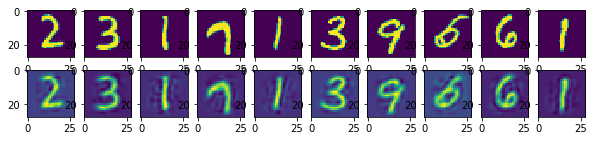

In [4]:
# Encoding X[0] for test
print("\nTest encoding of X[0]:")
# New model, re-using the same session, for weights sharing
encoding_model = tflearn.DNN(encoder, session=model.session)
print(encoding_model.predict([X[0]]))

# Testing the image reconstruction on new data (test set)
print("\nVisualizing results after being encoded and decoded:")
testX = tflearn.data_utils.shuffle(testX)[0]
# Applying encode and decode over test set
encode_decode = model.predict(testX)
# Compare original images with their reconstructions
f, a = plt.subplots(2, 10, figsize=(10, 2))
for i in range(10):
    a[0][i].imshow(np.reshape(testX[i], (28, 28)))
    a[1][i].imshow(np.reshape(encode_decode[i], (28, 28)))

f.savefig('f.png')
#f.show()
plt.draw()
#plt.waitforbuttonpress()

In [6]:
import tensorflow as tf
import numpy as np

In [7]:
from IPython.display import clear_output, Image, display, HTML

# Helper functions for TF Graph visualization
def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = bytes(""%size, 'utf-8')
    return strip_def
  
def rename_nodes(graph_def, rename_func):
    res_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = res_def.node.add() 
        n.MergeFrom(n0)
        n.name = rename_func(n.name)
        for i, s in enumerate(n.input):
            n.input[i] = rename_func(s) if s[0]!='^' else '^'+rename_func(s[1:])
    return res_def
  
def show_graph(graph_def=None, max_const_size=32):
    """Visualize TensorFlow graph."""
    
    # If no input graph is given, get the default graph
    if graph_def is None:
        graph_def = tf.get_default_graph().as_graph_def()
        
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))
  
    iframe = """
        <iframe seamless style="width:800px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [8]:
tf.reset_default_graph()  # To clear the default graph 

# Create the model
def deepnn(x):
  """deepnn builds the graph for a deep net for classifying digits.

  Args:
    x: an input tensor with the dimensions (N_examples, 784), where 784 is the
    number of pixels in a standard MNIST image.

  Returns:
    A tuple (y, keep_prob). y is a tensor of shape (N_examples, 10), with values
    equal to the logits of classifying the digit into one of 10 classes (the
    digits 0-9). keep_prob is a scalar placeholder for the probability of
    dropout.
  """
  # Reshape to use within a convolutional neural net.
  # Last dimension is for "features" - there is only one here, since images are
  # grayscale -- it would be 3 for an RGB image, 4 for RGBA, etc.
  x_image = tf.reshape(x, [-1, 28, 28, 1])

  # First convolutional layer - maps one grayscale image to 32 feature maps.
  W_conv1 = weight_variable([5, 5, 1, 32])
  b_conv1 = bias_variable([32])
  h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)

  # Pooling layer - downsamples by 2X.
  h_pool1 = max_pool_2x2(h_conv1)

  # Second convolutional layer -- maps 32 feature maps to 64.
  W_conv2 = weight_variable([5, 5, 32, 64])
  b_conv2 = bias_variable([64])
  h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)

  # Second pooling layer.
  h_pool2 = max_pool_2x2(h_conv2)

  # Fully connected layer 1 -- after 2 round of downsampling, our 28x28 image
  # is down to 7x7x64 feature maps -- maps this to 1024 features.
  W_fc1 = weight_variable([7 * 7 * 64, 1024])
  b_fc1 = bias_variable([1024])

  h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
  h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

  # Dropout - controls the complexity of the model, prevents co-adaptation of
  # features.
  keep_prob = tf.placeholder(tf.float32)
  h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

  # Map the 1024 features to 10 classes, one for each digit
  W_fc2 = weight_variable([1024, 10])
  b_fc2 = bias_variable([10])

  y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2
  return y_conv, keep_prob


def conv2d(x, W):
  """conv2d returns a 2d convolution layer with full stride."""
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')


def max_pool_2x2(x):
  """max_pool_2x2 downsamples a feature map by 2X."""
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')


def weight_variable(shape):
  """weight_variable generates a weight variable of a given shape."""
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)


def bias_variable(shape):
  """bias_variable generates a bias variable of a given shape."""
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

# Create the model
x = tf.placeholder(tf.float32, [None, 784])

# Define loss and optimizer
y_ = tf.placeholder(tf.float32, [None, 10])

# Build the graph for the deep net
y_conv, keep_prob = deepnn(x)

show_graph()